In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

In [2]:
movies=pd.read_csv('merged_movie.csv')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4775 non-null   object 
 2   keywords              4391 non-null   object 
 3   original_language     4803 non-null   object 
 4   overview              4800 non-null   object 
 5   popularity            4803 non-null   float64
 6   production_companies  4452 non-null   object 
 7   production_countries  4629 non-null   object 
 8   release_date          4802 non-null   object 
 9   revenue               4803 non-null   int64  
 10  runtime               4801 non-null   float64
 11  spoken_languages      4716 non-null   object 
 12  status                4803 non-null   object 
 13  tagline               3959 non-null   object 
 14  title                 4803 non-null   object 
 15  vote_average         

In [4]:
# content-based recommendation
# step 1: select 'genre','keywords','cast_names','crew_names' to combine as a feature.
movies['combined_features'] = (
    movies['genres'].fillna('') + ' ' + 
    movies['keywords'].fillna('') + ' ' + 
    movies['cast_names'].fillna('')+ ' ' +
    movies['crew_names'].fillna('')+ ' ' +
    movies['overview'].fillna('')    
)
# step 2: calculate the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['combined_features'])

# step 3: calculate the similarity of cosine
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# step 4: recommendation based on the movie title
def recommend_movies(movie_title, num_recommendations):
    # get the target movie index. Here it locates the first movie.
    movie_idx = movies[movies['title'] == movie_title].index[0]
    
    #  get the similarity score with this movie
    sim_scores = list(enumerate(cosine_sim[movie_idx]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # recommendate similar movies
    sim_scores = sim_scores[1:num_recommendations + 1]
    movie_indices = [idx for idx, score in sim_scores]
    suggest_idx = [score[0] for score in sim_scores]
    suggest_score = [score[1] for score in sim_scores]
    recommend_movies = movies.iloc[suggest_idx]['title']
    return pd.DataFrame({'Title': recommend_movies, 'Similarity Score': suggest_score})

# sample
recommendations = recommend_movies('Avatar', 5)
recommendations

,Title,Similarity Score
4,John Carter,0.129283
25,Titanic,0.127833
47,Star Trek Into Darkness,0.125006
3,The Dark Knight Rises,0.123961
149,Armageddon,0.122957


In [5]:
# KNN recommendation

# step 1: select features
movie_features = movies[['vote_average', 'vote_count', 'popularity']].fillna(0)

# step 2: standardize the feature
scaler = StandardScaler()
scaled_features = scaler.fit_transform(movie_features)

# step 3: use cosine value to define the neighbours
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(scaled_features)

# step 4 : define the function
def knn_recommend(movie_title, n_neighbors=5):
    movie_idx = movies[movies['title'] == movie_title].index[0]
    distances, indices = knn.kneighbors([scaled_features[movie_idx]], n_neighbors=n_neighbors + 1)
    recommended_movies = movies.iloc[indices[0][1:]][['title', 'vote_average', 'vote_count', 'popularity']]
    return recommended_movies

# sample
knn_recommend('Avatar', 5)


,title,vote_average,vote_count,popularity
58,Rush Hour 3,6.1,783,22.571780
129,Thor,6.6,6525,86.493424
98,The Hobbit: An Unexpected Journey,7.0,8297,108.849621
16,The Avengers,7.4,11776,144.448633
228,Oblivion,6.4,4800,67.698004


In [5]:
# score-genres based filter
# calculate the weighted score
m = movies['vote_count'].quantile(0.75)  # use the 0.75 quantile as the minimum
C = movies['vote_average'].mean()  

def weighted_rating(row, m=m, C=C):
    v = row['vote_count']
    R = row['vote_average']
    return (v / (v + m) * R) + (m / (v + m) * C)

movies['weighted_rating'] = movies.apply(weighted_rating, axis=1)


def get_score_based_recommendations(genre=None, data=movies, top_n=10):
    if genre:
        filtered_data = data[movies['genres'].str.contains(genre, case=False, na=False)]
    else:
        filtered_data = data
    top_movies = filtered_data.sort_values('weighted_rating', ascending=False).head(top_n)
    return top_movies[['title', 'vote_average', 'vote_count', 'weighted_rating']]

# sample
print("Top 10 Weighted_rating:")
print(get_score_based_recommendations())
print("\nTop 10 Action Movies:")
print(get_score_based_recommendations('Action'))

Top 10 Weighted_rating:
                         title  vote_average  vote_count  weighted_rating
1881  The Shawshank Redemption           8.5        8205         8.301547
3337             The Godfather           8.4        5893         8.143459
662                 Fight Club           8.3        9413         8.139688
3232              Pulp Fiction           8.3        8428         8.122458
65             The Dark Knight           8.2       12002         8.078054
809               Forrest Gump           8.2        7927         8.020698
96                   Inception           8.1       13752         7.997869
1818          Schindler's List           8.3        4329         7.978806
3865                  Whiplash           8.3        4254         7.973979
95                Interstellar           8.1       10867         7.972478

Top 10 Action Movies:
                                                  title  vote_average  \
65                                      The Dark Knight           

In [6]:
# combine weighted_rating and K-means recommendation. So it can get the highest weighted_rating movies in the same cluster.


num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
movies['cluster'] = kmeans.fit_predict(tfidf_matrix)

def get_cluster_based_recommendations(title, data=movies, top_n=10):
    idx = data[movies['title'] == title].index[0]
    cluster = data['cluster'].iloc[idx]
    cluster_movies = data[data['cluster'] == cluster]
    top_movies = cluster_movies.sort_values('weighted_rating', ascending=False).head(top_n)
    return top_movies[['title', 'vote_average', 'vote_count', 'weighted_rating']]


print(get_cluster_based_recommendations('Avatar'))

                                              title  vote_average  vote_count  \
1881                       The Shawshank Redemption           8.5        8205   
662                                      Fight Club           8.3        9413   
3232                                   Pulp Fiction           8.3        8428   
65                                  The Dark Knight           8.2       12002   
809                                    Forrest Gump           8.2        7927   
3865                                       Whiplash           8.3        4254   
95                                     Interstellar           8.1       10867   
1990                        The Empire Strikes Back           8.2        5879   
329   The Lord of the Rings: The Return of the King           8.1        8064   
2912                                      Star Wars           8.1        6624   

      weighted_rating  
1881         8.301547  
662          8.139688  
3232         8.122458  
65          

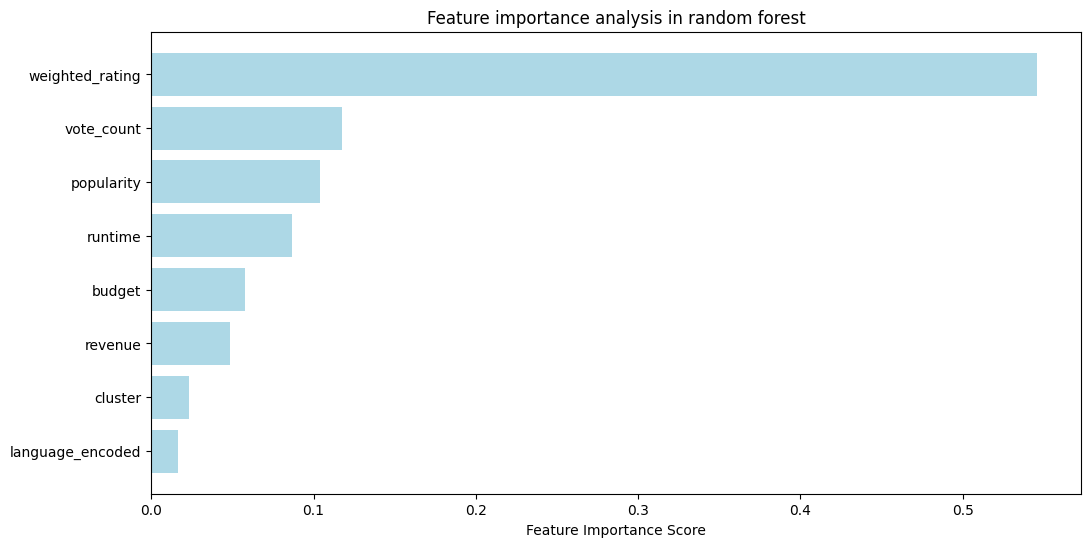

In [7]:
# use random forest to predict a movie belongs to high rating group or not. And find which features contribute most.
# encode the feature of 'original_language'
le = LabelEncoder()
movies['language_encoded'] = le.fit_transform(movies['original_language'])

movies['high_rating']=(movies['vote_average'] >= 7.0).astype(int)

# select all numerical features and drop irrelevant features.
numerical_features = movies.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['movie_id', 'vote_average','high_rating']]

x = movies[numerical_features].fillna(0)
y = movies['high_rating']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

# get the important features
importances = rf.feature_importances_
feature_names = np.array(numerical_features)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.barh(feature_names[indices], importances[indices], color="lightblue")
plt.xlabel("Feature Importance Score")
plt.title("Feature importance analysis in random forest")
plt.gca().invert_yaxis() 
plt.show()

In [8]:
# Define when 'vote_average' is higher than 7, it is high rating.
movies['high_rating'] = (movies['vote_average'] >= 7.0).astype(int)

# select the important features above
features = ['vote_count', 'runtime', 'popularity', 'budget', 'revenue']
x = movies[features].fillna(0)
y = movies['high_rating']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)

y_pred = rf_classifier.predict(x_test)


accuracy = accuracy_score(y_test, y_pred)
f"the prediction accuracy of high rating: {accuracy:.4f}"


'the prediction accuracy of high rating: 0.8383'

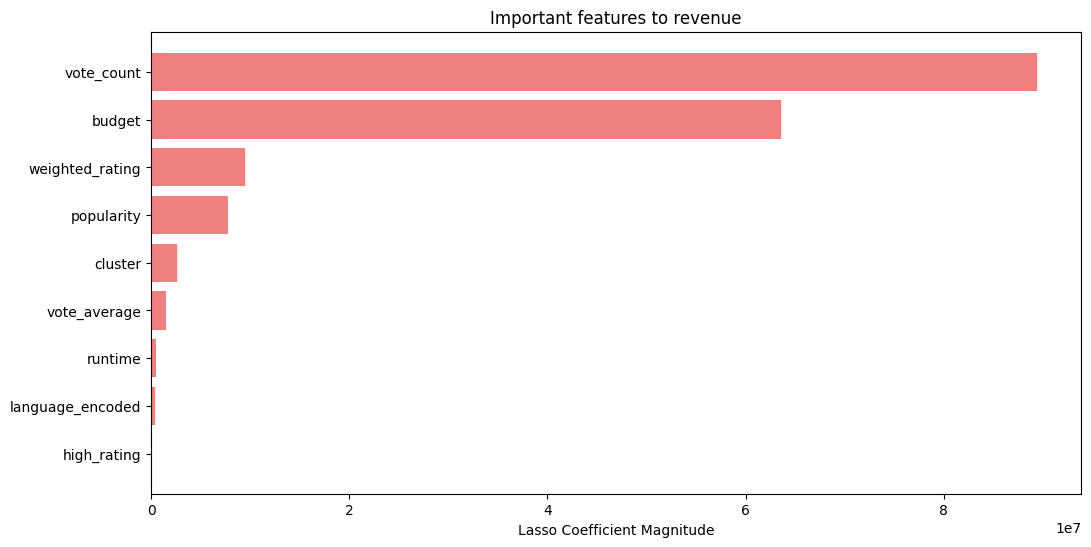

In [9]:
# use Lasso to get the most significant features and then use logistic regression to predict revenue
# Scale the data
numerical_features = movies.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['movie_id', 'revenue']]

x = movies[numerical_features].fillna(0)
y = movies['revenue']
feature_names=np.array(x.columns)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(x_scaled, y)

# calculate the feature importance coefficient
lasso_importance = np.abs(lasso.coef_)

# sort by importance
indices = np.argsort(lasso_importance)[::-1]

plt.figure(figsize=(12, 6))
plt.barh(feature_names[indices], lasso_importance[indices], color="lightcoral")
plt.xlabel("Lasso Coefficient Magnitude")
plt.title("Important features to revenue")
plt.gca().invert_yaxis()
plt.show()


selected_features = feature_names[lasso_importance > 0]


In [10]:
# use logistic regression to predict revenue
x_lr=movies[['vote_count','budget','popularity']].copy()
y=movies['revenue'].copy()
x_lr.dropna(inplace=True)
y=y.loc[x_lr.index]

scaler = StandardScaler()
x_lr = scaler.fit_transform(x_lr)
threshold=y.median()
y=(y >= threshold).astype(int) # when revenue is higher than revenue median, than it is regarded as high revenue movies.

x_train, x_test, y_train, y_test = train_test_split(x_lr, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression(random_state=42, max_iter=5000,solver='liblinear')
log_reg.fit(x_train, y_train)

#evaluate the model
y_pred = log_reg.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
f'prediction accuracy is : {accuracy:.4f}'

'prediction accuracy is : 0.8522'

In [11]:
movies.to_csv('merged_movie.csv',index=False)